In [245]:
import requests
from bs4 import BeautifulSoup
from lxml import etree
import pandas as pd

In [246]:
headers = {
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36",
}
url_inegi   = 'https://cuentame.inegi.org.mx/monografias/informacion/mex/poblacion/default.aspx?tema=me&e=15' 
url_edomex  = 'https://salud.edomex.gob.mx/salud/covid19_municipio'

# Extracción de datos mediante request y pandas

In [247]:
respuesta_inegi = requests.get(url_inegi, headers=headers)
respuesta_edo = requests.get(url_edomex, headers=headers)
print('validando url inegi', respuesta_inegi)
print('validando url edomex', respuesta_edo)

validando url inegi <Response [200]>
validando url edomex <Response [200]>


In [248]:
parse = etree.HTML(respuesta_inegi.text)

name = parse.xpath('//table[@id="keywords2"]/tbody/tr')

table = []

for row in name:
    clave      = row.xpath('./td')[0].text
    municipio   = row.xpath('./td')[1].text
    habitantes  = row.xpath('./td')[2].text
    table.append({'clave_municipal': clave, 'municipio': municipio, 'habitantes': habitantes})

table_inegi = pd.DataFrame(table)

table_inegi.head()


,clave_municipal,municipio,habitantes
0,001,Acambay de Ruíz Castañeda,"67,872"
1,002,Acolman,"171,507"
2,003,Aculco,"49,266"
3,004,Almoloya de Alquisiras,"15,333"
4,005,Almoloya de Juárez,"174,587"


In [249]:
tabla = pd.read_html(respuesta_edo.content)
table_edo = tabla[0]
table_edo.head()

,Municipio,Casos,Defunciones
0,Ecatepec de Morelos,23799,3141.0
1,Nezahualcóyotl,18330,1081.0
2,Toluca,14387,2373.0
3,Naucalpan,13338,1315.0
4,Tlalnepantla,11358,1059.0


# 2 - Exploración de datos y limpieza de datos

renombrammos el nombre de las columnas para poder hacer las uniones

In [250]:
table_edo = table_edo.rename(columns={"Municipio": "municipio", "Casos": "casos", "Defunciones": "defunciones"})

table_edo.head()


,municipio,casos,defunciones
0,Ecatepec de Morelos,23799,3141.0
1,Nezahualcóyotl,18330,1081.0
2,Toluca,14387,2373.0
3,Naucalpan,13338,1315.0
4,Tlalnepantla,11358,1059.0


In [251]:
tabla_covid = pd.merge(table_edo,table_inegi, on="municipio", how="inner")

In [252]:
tabla_covid.head()

,municipio,casos,defunciones,clave_municipal,habitantes
0,Nezahualcóyotl,18330,1081.0,058,"1,077,208"
1,Toluca,14387,2373.0,106,"910,608"
2,Chalco,7921,1317.0,025,"400,057"
3,Tultitlán,5903,1026.0,109,"516,341"
4,Ixtapaluca,5437,591.0,039,"542,211"


Eliminados la clave municipal ya que no se necesitara para hacer algun analisis

In [253]:
tabla_covid = tabla_covid.drop(columns=["clave_municipal"])

In [254]:
tabla_covid.head()

,municipio,casos,defunciones,habitantes
0,Nezahualcóyotl,18330,1081.0,"1,077,208"
1,Toluca,14387,2373.0,"910,608"
2,Chalco,7921,1317.0,"400,057"
3,Tultitlán,5903,1026.0,"516,341"
4,Ixtapaluca,5437,591.0,"542,211"


validamos el dataset y los tipos de datos

In [255]:
tabla_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   municipio    90 non-null     object 
 1   casos        90 non-null     int64  
 2   defunciones  90 non-null     float64
 3   habitantes   90 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.5+ KB


cambiamos el tipo de dato habitantes de object a int


In [256]:
tabla_covid['habitantes'] = tabla_covid['habitantes'].str.replace(',', '').astype(int)
tabla_covid['defunciones'] = tabla_covid['defunciones'].astype(int)


In [257]:
tabla_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   municipio    90 non-null     object
 1   casos        90 non-null     int64 
 2   defunciones  90 non-null     int32 
 3   habitantes   90 non-null     int32 
dtypes: int32(2), int64(1), object(1)
memory usage: 2.8+ KB


guardamos el dataset

In [258]:
tabla_covid.to_csv('../files/tablacovid.csv',header="True")

# Visualización de datos

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

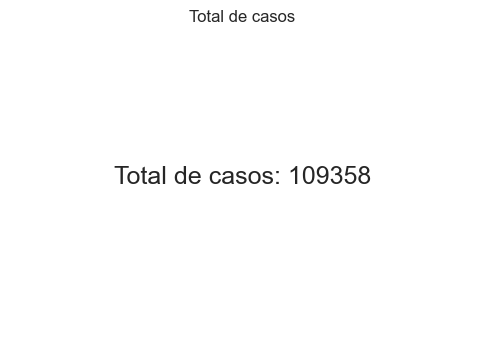

In [260]:
total_casos = tabla_covid['casos'].sum()

plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, f'Total de casos: {total_casos}', fontsize=18, ha='center')
plt.axis('off')  # Desactivar ejes
plt.title('Total de casos')
plt.show()


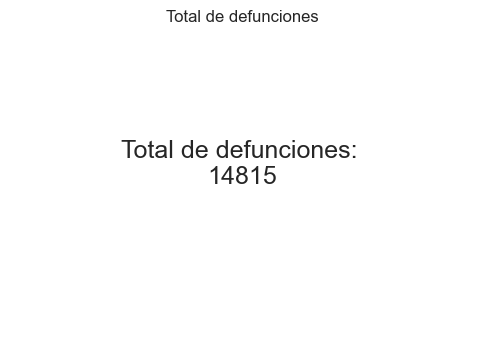

In [275]:
total_defunciones = tabla_covid['defunciones'].sum()

plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, f'Total de defunciones: \n{total_defunciones}', fontsize=18, ha='center')
plt.axis('off')  # Desactivar ejes
plt.title('Total de defunciones')
plt.show()



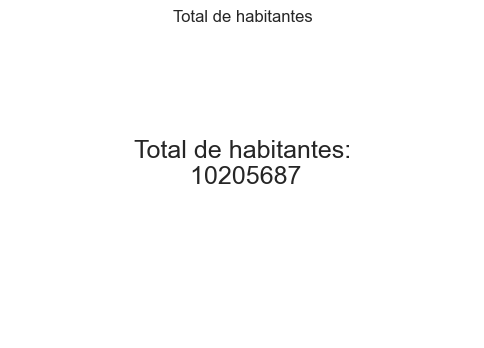

In [273]:
total_habitantes = tabla_covid['habitantes'].sum()

plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, f'Total de habitantes:\n {total_habitantes}', fontsize=18, ha='center')
plt.axis('off')  # Desactivar ejes
plt.title('Total de habitantes')
plt.show()

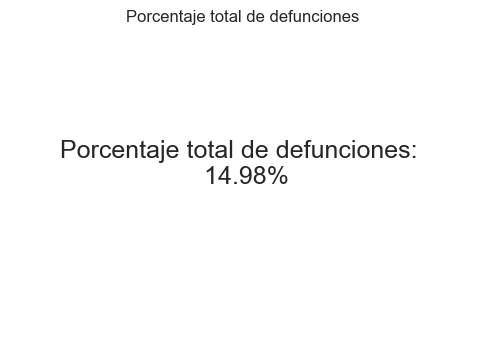

In [272]:
tabla_covid['Tasa de defunciones'] = (tabla_covid['defunciones'] / tabla_covid['casos']) * 100
tabla_covid['Tasa de defunciones'] = tabla_covid['Tasa de defunciones'].round(2)

suma_tasas_defunciones = tabla_covid['Tasa de defunciones'].sum()
num_filas = len(tabla_covid)
promedio_tasa_defunciones = suma_tasas_defunciones / num_filas


# Crear una tarjeta para mostrar el porcentaje total de defunciones
plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, f'Porcentaje total de defunciones: \n {promedio_tasa_defunciones:.2f}%', fontsize=18, ha='center')
plt.axis('off')  # Desactivar ejes
plt.title('Porcentaje total de defunciones')
plt.show()


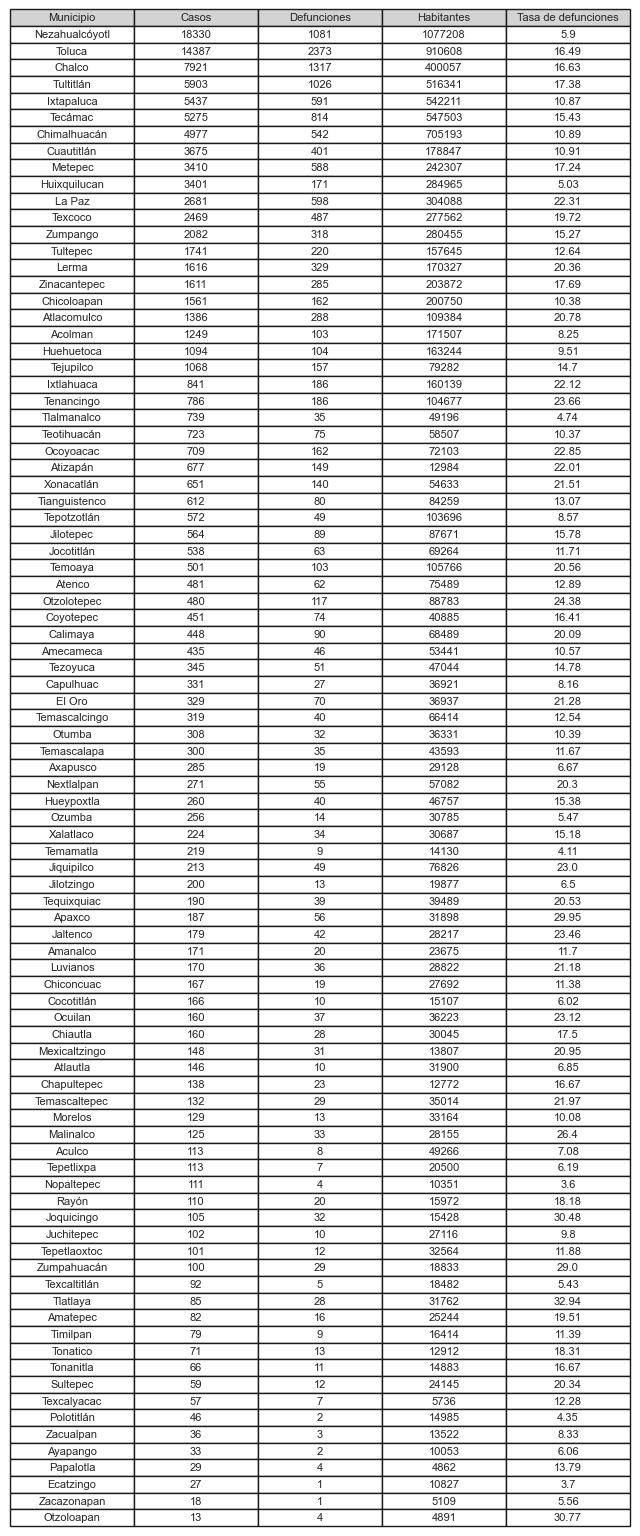

In [269]:


# Crear la tabla con Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  

# Encabezado
header = ["Municipio", "Casos", "Defunciones", "Habitantes", "Tasa de defunciones"]
data = tabla_covid.values.tolist()


# Dibujar la tabla
ax.table(cellText=data, colLabels=header, loc='center', cellLoc='center', colColours=['lightgray']*len(header))
plt.show()


en la siguiente gráfica mostramos la correlación por cada uno las métricas

C:\Users\CENTRAL MEDIA\AppData\Local\Temp\ipykernel_20240\723236505.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlaciones = tabla_covid.corr()


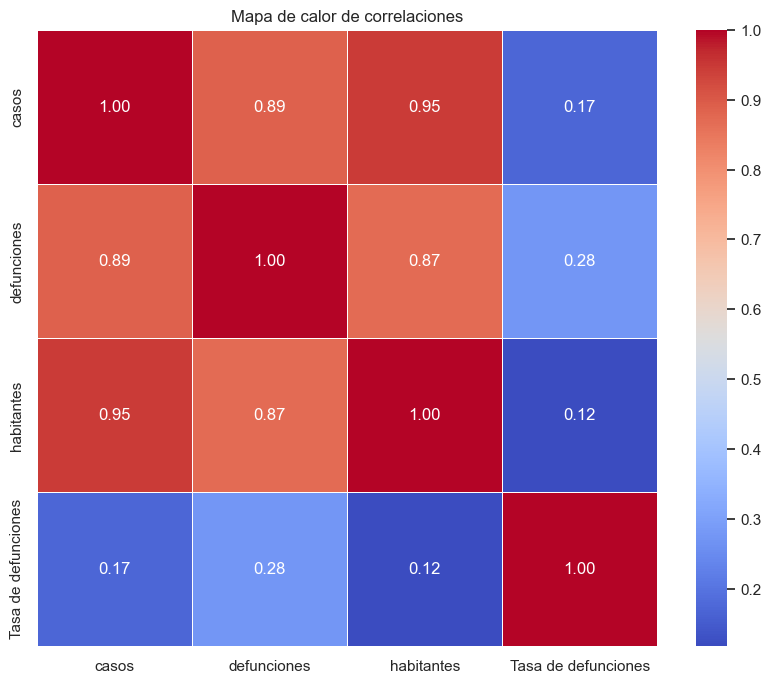

In [265]:

correlaciones = tabla_covid.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de calor de correlaciones')
plt.show()


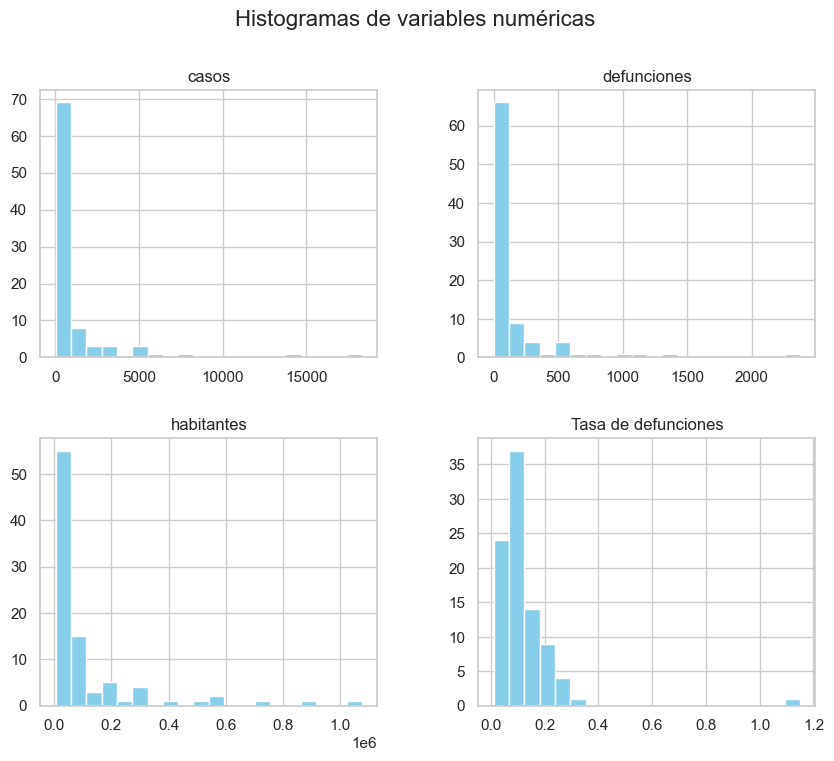

In [266]:

tabla_covid.hist(figsize=(10, 8), bins=20, color='skyblue')
plt.suptitle('Histogramas de variables numéricas', fontsize=16)
plt.show()

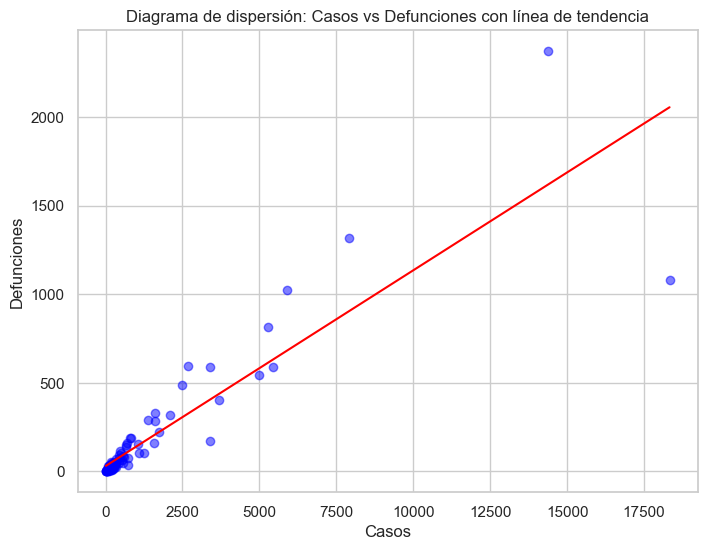

In [267]:
slope, intercept = np.polyfit(tabla_covid['casos'], tabla_covid['defunciones'], 1)

# Crear un diagrama de dispersión entre las columnas 'casos' y 'defunciones'
plt.figure(figsize=(8, 6))
plt.scatter(tabla_covid['casos'], tabla_covid['defunciones'], color='blue', alpha=0.5)
plt.title('Diagrama de dispersión: Casos vs Defunciones con línea de tendencia')
plt.xlabel('Casos')
plt.ylabel('Defunciones')
plt.grid(True)

# Linea de tendencia
plt.plot(tabla_covid['casos'], slope*tabla_covid['casos'] + intercept, color='red')

plt.show()

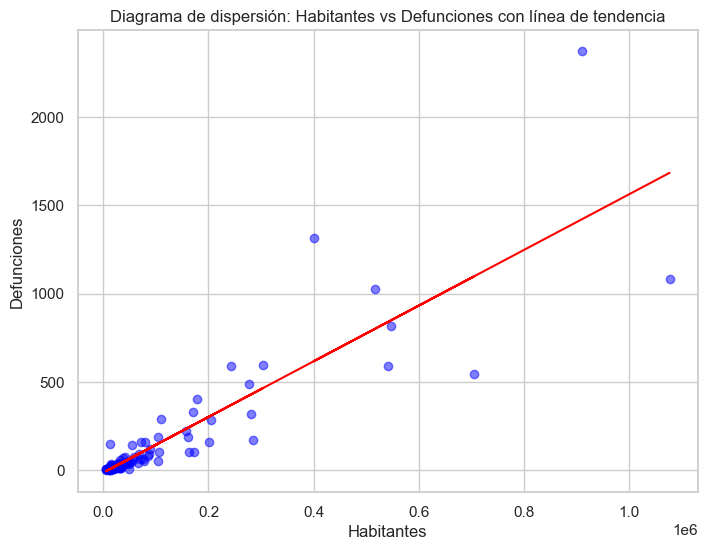

In [268]:
slope, intercept = np.polyfit(tabla_covid['habitantes'], tabla_covid['defunciones'], 1)

# Crear un diagrama de dispersión entre las columnas 'habitantes' y 'defunciones'
plt.figure(figsize=(8, 6))
plt.scatter(tabla_covid['habitantes'], tabla_covid['defunciones'], color='blue', alpha=0.5)
plt.title('Diagrama de dispersión: Habitantes vs Defunciones con línea de tendencia')
plt.xlabel('Habitantes')
plt.ylabel('Defunciones')
plt.grid(True)

# Linea de tendencia
plt.plot(tabla_covid['habitantes'], slope*tabla_covid['habitantes'] + intercept, color='red')

plt.show()